In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit,minimize
from scipy.interpolate import UnivariateSpline
import scipy
%matplotlib inline
from tqdm.auto import tqdm
import quaternion as quat

In [3]:
def chi2(y1,y2,sy):
    '''
    Compute the Chi2 value.
    '''
    return(np.sum(np.square(x-y)/sy**2))

def RK4(x,y0,func,dx=1,args=()):
    '''
    Compute the classic Runge-Kutta method in one dimension. 
    
    'func' is equal to dy/dx. 
    '''
    k1 = func(x,y0,*args)
    k2 = func(x+dx/2,y0+dx*k1/2,*args)
    k3 = func(x+dx/2,y0+dx*k2/2,*args)
    k4 = func(x+dx,y0+dx*k3,*args)
    
    return(x+dx,y0+(k1+2*k2+2*k3+k4)*dx/6)

def ML15(q,earth,a,b,c,sun=[1,0,0]):
    '''
    Compute the M&L lightcurve model.
    '''
    sun = quat.from_vector_part(sun) # turn the sun point to a quaternion
    
    sun   = q *  sun  * q.conj() # compute the sun vectors from rotations
    earth = q * earth * q.conj() # compute the earth vectors from rotations
    
    # get the vector parts of both vector sets
    sun   = quat.as_vector_part(sun) 
    earth = quat.as_vector_part(earth)
    
    C = np.array([1/a**2,1/b**2,1/c**2]) # compute the scaling matrix C
    
    # compute the scaling constants Tsun, Tearth
    Tsun   = np.sqrt(np.einsum('ij,j,ij->i',sun,C,sun))
    Tearth = np.sqrt(np.einsum('ij,j,ij->i',earth,C,earth))
    
    # compute cos(alpha)
    cosa = np.einsum('ij,j,ij->i',sun,C,earth)/(Tearth*Tsun) 
    cosa = np.minimum(cosa,1)
    cosa = np.maximum(cosa,-1)
    
    # compute alpha
    aprime = np.arccos(cosa)
    aprime[np.isclose(aprime,0)]=0
    
    # compute scaling constant T
    T=np.sqrt(np.abs(Tsun**2 + Tearth**2 + 2*Tsun*Tearth*cosa))
    
    # compute cos(lambda) and sin(lambda)
    cosl=np.nan_to_num((Tsun+Tearth*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((Tearth*np.sin(aprime))/T,posinf=0,neginf=0)

    # compute the lambda values
    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    # compute the tan and cotan
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    # compute the M&L brightness
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    
    return(np.abs(L))

def min_func(p,a,b,c,sun):
    x,y,z = p
    out = (x**2/a**4+y**2/b**4+z**2/c**4)**(-1/2)*np.array([x/a**2,y/b**2,z/c**2])+sun
    return(np.max(np.abs(out)))

def substellar_pt(q,a,b,c,sun=[1,0,0]):
    '''
    Compute the position of the outgassing from the body.
    
    q is the ATTITUDE quaternion, not the VELOCITY quaternion.
    '''
    from scipy.optimize import minimize
    
    
    sun = quat.from_vector_part(sun) # turn the sun point to a quaternion
    sun = q.conj() * sun * q # compute the sun vectors from rotations
    sun = quat.as_vector_part(sun)
    
    constraint = {'type': 'eq',
           'fun' : lambda x: np.array([x[0]**2/a**2+x[1]**2/b**2+x[2]**2/c**2-1]),
           'jac' : lambda x: 2*np.array([x[0]/a**2,x[1]/b**2,x[2]/c**2])}
    
    p = minimize(min_func,(a,0,0),args=(a,b,c,sun),method='SLSQP',
                 constraints=[constraint],options={'ftol': 1e-9})
    
    return(p.x)

def ellipse_grad(r,a,b,c):
    '''
    Compute the gradient of the ellipse.
    '''
    x,y,z = r
    return((x**2/a**4+y**2/b**4+z**2/c**4)**(-1/2)*np.array([x/a**2,y/b**2,z/c**2]))

def comp_torque(r,a,b,c,M=1,A=1):
    '''
    Compute the torque based on the substellar outgassing.
    '''
    return(M*A*np.cross(r,ellipse_grad(r,a,b,c)))

def comp_MoI(a,b,c):
    return(1/5*np.array([b**2+c**2,a**2+c**2,a**2+b**2]))

def rot_time_step(t0,qp,qw,a,b,c,dt=1):
    '''
    Compute and update the rotation axis.
    '''
    Ia,Ib,Ic = comp_MoI(a,b,c)
    
    w = quat.as_vector_part(qw)
    
    rss = substellar_pt(qp,a,b,c)
    
    def wadot(t,wa):
        wnew = w
        wnew[0] = wa
        
        return(w[1]*w[2]*(Ib-Ic)/Ia+
               comp_torque(rss,a,b,c)[0]/Ia)
    
    def wbdot(t,wb):
        wnew = w
        wnew[1] = wb
        
        return(w[0]*w[2]*(Ic-Ia)/Ib+
               comp_torque(rss,a,b,c)[1]/Ib)
    
    def wcdot(t,wc):
        wnew = w
        wnew[1] = wc
        
        return(w[0]*w[1]*(Ia-Ib)/Ic+
               comp_torque(rss,a,b,c)[2]/Ic)
    
    wnew = np.zeros_like(w)
    xnew,wnew[0] = RK4(t0,w[0],wadot,dt)
    xnew,wnew[1] = RK4(t0,w[1],wbdot,dt)
    xnew,wnew[2] = RK4(t0,w[2],wcdot,dt)
    
    return(quat.from_vector_part(wnew))

def update_attitude(qp,qw,dt):
    nqp = qp + qw*qp*dt/2
    return(nqp)


In [4]:
class Lightcurve_Data():
    def __init__(self,file):
        data = pd.read_csv(file,comment='#')
        
        self.time = data['corrMMJD'].to_numpy()
        self.mag = data['corrm'].to_numpy()
        self.std = data['sigma'].to_numpy()
        self.phase = data['aPh'].to_numpy()
        
belton = Lightcurve_Data("../Lightcurves/Photometry/1I_2017U1_lightcurve.csv")

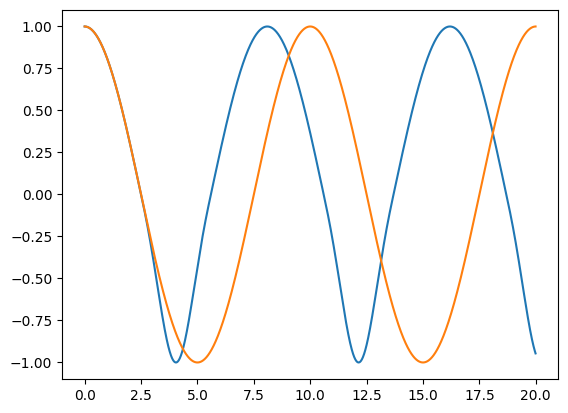

In [5]:
P = 10

qw = quat.from_vector_part(np.array([0,2*np.pi/P,0]))
qp = np.quaternion(1,0,0,0)

att = []
time = []

t = 0
dt = 0.01
while t < 20:
    att.append((qp*np.quaternion(0,1,0,0)*qp.conj()).x)
   
    qw = rot_time_step(0,qp,qw,6,6,1,dt)
    qp = update_attitude(qp,qw,dt)
    qp *= 1/qp.norm()

    time.append(t)
    t+=dt

tatt=(np.cos(2*np.pi*(np.array(time)%P)/P))

plt.plot(time,att)
plt.plot(time,tatt)
plt.show()

In [402]:
# Test the sub-stellar point
a,b,c = 6,6,1

q = quat.from_rotation_vector([0,0.5,0])

sun = (q.conj()*quat.from_vector_part([1,0,0])*q).vec

norm = np.sqrt(np.dot([a**2,b**2,c**2],np.square(sun)))

print(norm)

xp = -a**2*sun[0]/norm
yp = -b**2*sun[1]/norm
zp = -c**2*sun[2]/norm
print(xp,yp,zp)

print((xp/a)**2+(yp/b)**2+(zp/c)**2)
print(ellipse_grad([xp,yp,zp],6,6,1))
print(sun)

5.287276269752929
-5.975283041059956 -0.0 -0.0906753334125675
1.0000000000000002
[-0.87758256 -0.         -0.47942554]
[0.87758256 0.         0.47942554]
